In [1]:
import pandas as pd
import os
import io
import re
from tqdm import tqdm
import pickle
import math

In [2]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/moss'
file_name = '1821_1935_2023.csv'

moss_folder = os.path.join(folder_directory, file_name)

In [59]:
moss_data = pd.read_csv(moss_folder)

In [60]:
moss_data.sample(10)

,mission,cohort1,assessment1,submission1,name1,cohort2,assessment2,submission2,name2,percent1,percent2,lines,url
3199,rune_reading,1935,38701,1012698,keith_scott,1935,38701,1016972,ariel_duran,43,51,26,http://moss.stanford.edu/results/8/89744940683...
3517,hungry_games_training_part_i,1821,33164,942664,joseph_snyder,1935,39736,1081231,amy_miller,15,18,50,http://moss.stanford.edu/results/4/26835405649...
2508,2048_game,1821,33163,917678,misty_ramsey,1821,33163,926443,james_davis,50,50,99,http://moss.stanford.edu/results/2/62847504417...
717,cheryl_s_birthday,1821,33175,909859,amanda_smith,2023,41890,1194327,benjamin_cole,40,45,39,http://moss.stanford.edu/results/5/39427621671...
1389,book_of_advanced_spells,1821,33172,878370,jose_rodriguez,1821,33172,876578,mark_fuller,66,65,20,http://moss.stanford.edu/results/5/88376757115...
201,dna_using_data_directed_programming,1935,39561,1085153,raymond_adams,1935,39561,1083610,christopher_anderson,24,41,35,http://moss.stanford.edu/results/0/10303382188...
653,cheryl_s_birthday,1935,38726,1067029,heather_english,2023,41890,1181076,peter_callahan,39,43,29,http://moss.stanford.edu/results/5/39427621671...
235,dna_using_data_directed_programming,1935,39561,1075309,carrie_phillips,1935,39561,1075967,martha_ramirez,33,25,33,http://moss.stanford.edu/results/0/10303382188...
2816,more_than_thrice,1935,38712,1031959,bryce_cain,2023,41897,1149344,brianna_lopez,29,33,37,http://moss.stanford.edu/results/3/69248926195...
3277,writing_a_sorting_spell,1935,38694,1069704,jeffrey_thornton,1935,38694,1070848,bobby_flores,28,36,50,http://moss.stanford.edu/results/3/80555807393...


In [61]:
moss_data.shape

(4134, 13)

In [62]:
## Task 1 (edges)

moss_data = moss_data[moss_data['name1'] != moss_data['name2']]

In [63]:
import torch

unsorted_pairs = [(rows.name1, rows.name2) for _, rows in moss_data.iterrows() if rows.name1 != rows.name2]
pairs = []
for pair in unsorted_pairs:
    a = (pair[0], pair[1])
    b = (pair[1], pair[0])
    if a in pairs or b in pairs:
        continue
    else:
        pairs.append(pair)

sorted_pairs = sorted(set(pairs), key=lambda x: x[0])
# sorted_pairs = sorted(set(pairs), key=lambda x: (name_to_ID[x[0]], name_to_ID[x[1]]))
# tmp_s = list(map(lambda x: name_to_ID[x[0]], sorted_pairs))
# tmp_t = list(map(lambda x: name_to_ID[x[1]], sorted_pairs))
# src = []
# for i, j in zip(tmp_s, tmp_t):
#     src.append(i)
#     src.append(j)
# tgt = []
# for i, j in zip(tmp_s, tmp_t):
#     tgt.append(j)
#     tgt.append(i)
# edge_index = torch.tensor([src, tgt], dtype=torch.long)

In [64]:
## Name to dict

all_names = set([i for pair in sorted_pairs for i in pair])
name_to_ID = {name: i for i, name in enumerate(sorted(all_names))}
ID_to_name = {i: name for i, name in enumerate(sorted(all_names))}
name_ID_dict = {'all_names': all_names, 'name_to_ID': name_to_ID, 'ID_to_name': ID_to_name}

In [65]:
len(name_to_ID), name_to_ID['john_cuevas_md'], ID_to_name[476] ## Sanity Check

(1030, 476, 'john_cuevas_md')

In [66]:
pickle.dump(name_ID_dict, open('name_id_dict.pkl', 'wb'))

In [11]:
## Get file lengths

def get_file_length(file_path, template_path):
    student_file = [line.strip() for line in io.open(file_path, 'r', encoding='utf-8') if line.strip() != '']
    template_file = [line.strip() for line in io.open(template_path, 'r', encoding='utf-8') if line.strip() != '']
    unique_lines = set(student_file).difference(set(template_file))
    return len(unique_lines)

lengths_dict = {'1821': {}, '1935': {}, '2023': {}}

folder = '/Users/leonard.lee/Downloads/CS5340_Project/global_moss'
subfolders = moss_data['mission'].unique().tolist()
for path in tqdm(subfolders):
    jpath = os.path.join(folder, path)
    files = os.listdir(jpath)
    for file in files:
        if file.split('.')[0] in ['1821', '1935', '2023']:
            batch = file.split('.')[0]
            name = '.'.join(file.split('.')[3:-1])
            leng = get_file_length(os.path.join(jpath, file), os.path.join(folder, 'templates/{}.py'.format(path)))
            if path not in lengths_dict[batch]:
                lengths_dict[batch][path] = {}
            lengths_dict[batch][path][name] = leng

100%|██████████| 28/28 [00:12<00:00,  2.21it/s]


In [12]:
lengths_dict['1935']['dna_using_data_directed_programming']['nathaniel_hood']

42

In [67]:
## Standardise two percentages and extract rank

method_name = 'avg'

def standardise_method(name, percent1, percent2, offending_lines, names, batch, mission, leng_dic):
    if name == 'min':
        return min(percent1, percent2)
    elif name == 'max':
        return max(percent1, percent2)
    elif name == 'avg':
        return (percent1+percent2)/2
    elif name == 'uniq_lines':
        try:
            denom = min(leng_dic[str(batch[0])][mission][names[0]], leng_dic[str(batch[1])][mission][names[1]])
            return offending_lines/denom
        except:
            print(batch, mission, names)
            return 0

moss_data['standardised1'] = moss_data.apply(
    lambda x: standardise_method(method_name, x['percent1'], x['percent2'], 
                                 x['lines'], (x['name1'], x['name2']), 
                                 (x['cohort1'], x['cohort2']), x['mission'],
                                 lengths_dict),
    axis=1
)

pattern = re.compile(r'(match[0-9]+).html') ## Pattern to extract ranks
moss_data['Moss Rank'] = moss_data['url'].apply(lambda x: int(pattern.search(x)[0][5:-5]))

In [68]:
## Group and Rank by missions

grouped_moss_data = moss_data.groupby(["mission"])
mission_titles = grouped_moss_data['mission'].unique().index.tolist()
max_rank = dict(zip(grouped_moss_data['Moss Rank'].max().index, grouped_moss_data['Moss Rank'].max()))
mission_averages = grouped_moss_data['standardised1'].mean()
sorted_averages = sorted(zip(mission_averages.index, mission_averages), key=lambda x: x[1])
normalized_averages = dict(map(lambda x: (x[0], 1/x[1]), sorted_averages))

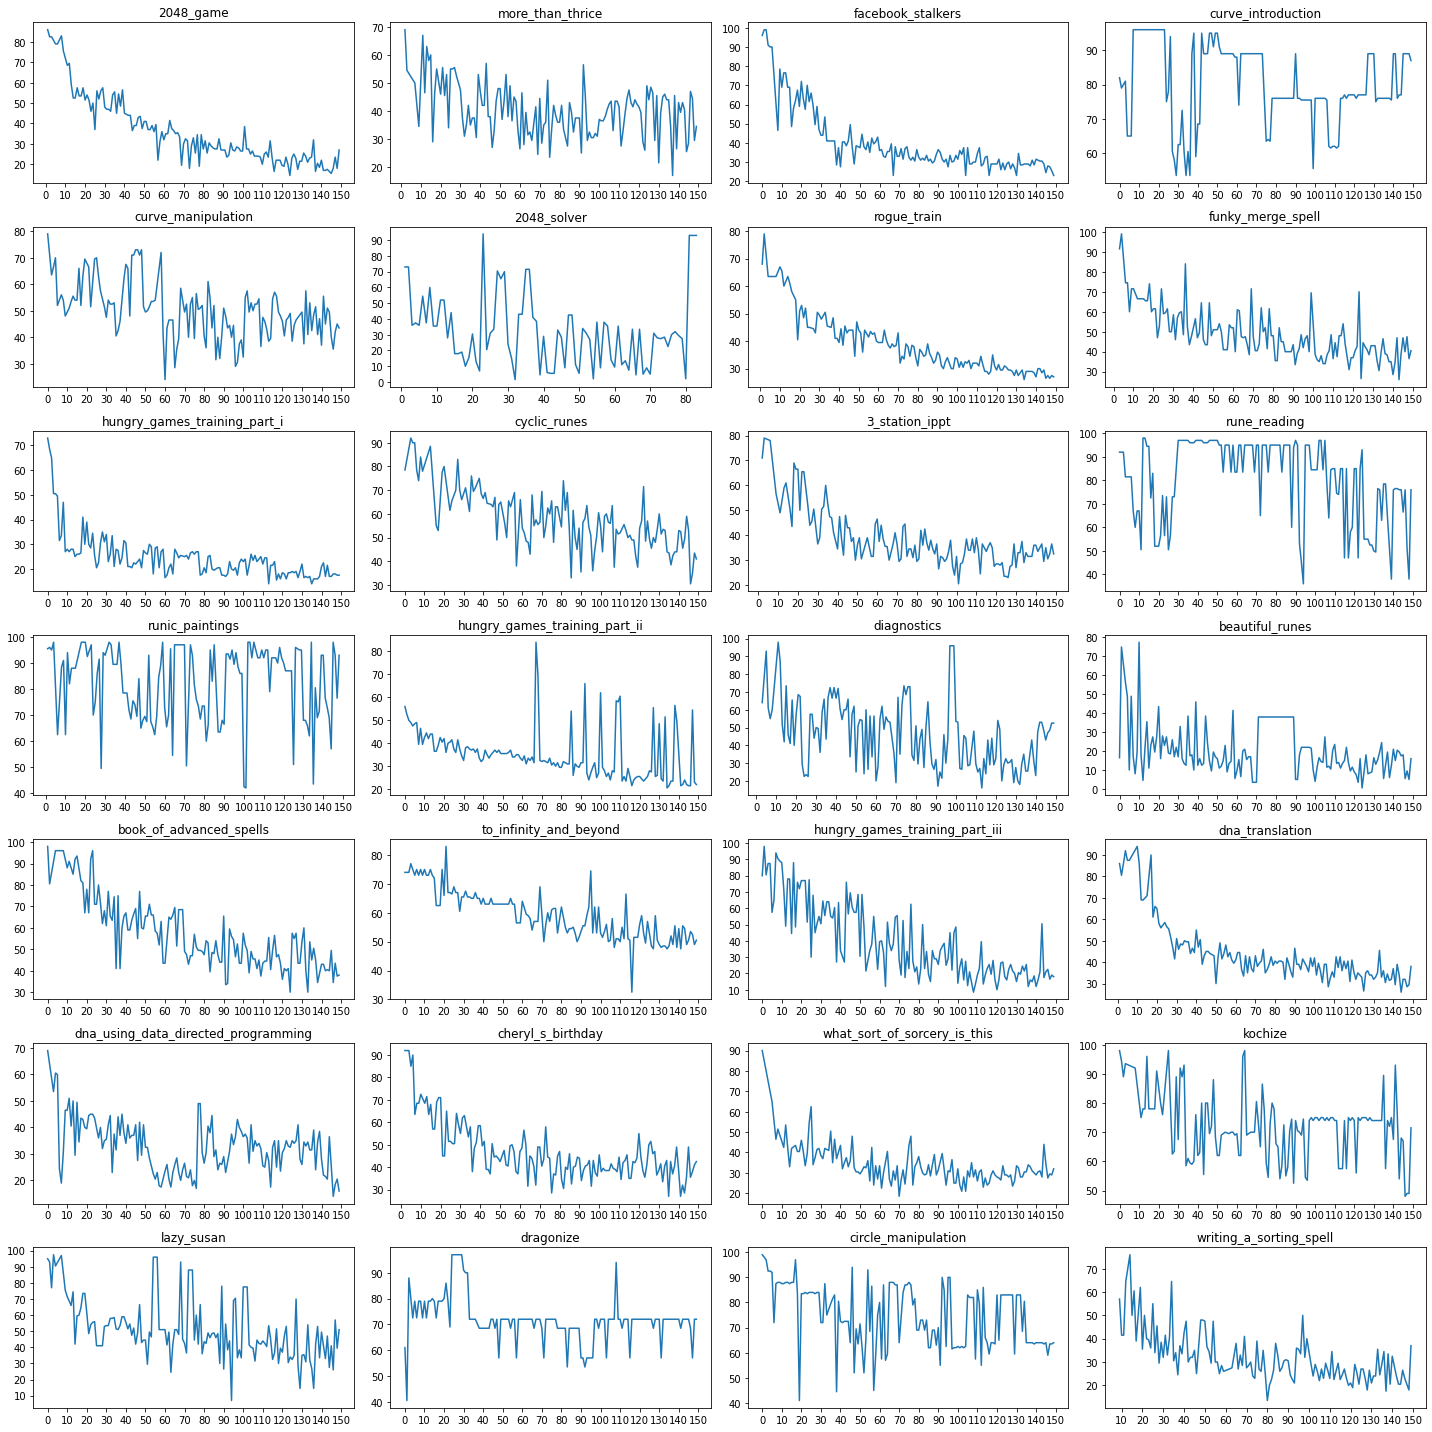

In [69]:
## Plot of Rank and Similarities

import numpy as np
import matplotlib.pyplot as plt

figure, ax = plt.subplots(nrows=7, ncols=4, figsize=[20, 20])
plt.setp(ax, xticks=[i for i in range(0, 151, 10)],
        yticks=[i for i in range(0, 101, 10)])
counter = 0
for name, group in grouped_moss_data:
    row, col = counter%7, counter%4
    x = np.array(group['Moss Rank'].tolist())
    y = np.array(group['standardised1'].tolist())
    ax[row, col].plot(x,y)
    ax[row, col].title.set_text('{}'.format(name))
    counter+=1
figure.tight_layout()

In [70]:
## Slice points by MOSS Rank

def points_aggregation(moss_rank, max_rank, points):
    return math.exp(-(moss_rank)/max_rank)*points

def obtain_points(moss_rank, mission, mrank, raverages):
    _max_rank = mrank[mission]
    points = raverages[mission]
    return points_aggregation(moss_rank, _max_rank, points)

moss_data['Points'] = moss_data.apply(lambda x: obtain_points(x['Moss Rank'], x['mission'], max_rank, normalized_averages), axis=1)

In [71]:
percentile_pairs = {}
for pairs in sorted_pairs:
    a = moss_data[(moss_data['name1'] == pairs[0]) & (moss_data['name2'] == pairs[1])]['Points'].sum()
    b = moss_data[(moss_data['name2'] == pairs[0]) & (moss_data['name1'] == pairs[1])]['Points'].sum()
    percentile_pairs[pairs] = a+b

In [72]:
# def normalizer(x, values):
#     maxx = max(values)
#     minn = min(values)
#     return (x-minn)/(maxx-minn)

# percentiles = dict(map(lambda x: (x[0], normalizer(x[1], percentile_pairs.values())), percentile_pairs.items()))

In [73]:
## Export from pandas to CSV

export_data = pd.DataFrame([], columns=['NodeID1', 'NodeID2', 'edge_weights'])
for pair in sorted_pairs:
    export_data=export_data.append({'NodeID1':pair[0], 'NodeID2':pair[1], 'edge_weights':percentile_pairs[pair]}, ignore_index=True)
    
export_data.to_csv('{}_edge_weights.csv'.format(method_name), index=False)

In [74]:
export_data.head()

,NodeID1,NodeID2,edge_weights
0,aaron_christian,marc_key,0.011628
1,aaron_christian,joseph_trevino,0.008216
2,aaron_pope,annette_solis,0.009414
3,aaron_pope,carol_harris,0.018713
4,aaron_powell,jennifer_simmons,0.009933


In [75]:
len(set(export_data.NodeID1.tolist() + export_data.NodeID2.tolist())), len(set(list(map(lambda x: x[0], sorted_pairs)) + list(map(lambda x: x[1], sorted_pairs))))

(1030, 1030)

In [76]:
## Sanity Check

dup_check = []

for pair in sorted_pairs:
    if pair[0] == pair[1]:
        print('Same pair alert: {}'.format(pair))
    elif (pair[1], pair[0]) in sorted_pairs:
        print('Non-unique pair alert: {}'.format(pair))
    elif pair in dup_check:
        print('Duplicate alert: {}'.format(pair))
        dup_check.append(pair)

In [109]:
## Sanity Check

check_data = pd.read_csv('uniq_lines_edge_weights.csv')
a=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
a1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('min_edge_weights.csv')
b=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
b1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('max_edge_weights.csv')
c=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
c1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
check_data = pd.read_csv('avg_edge_weights.csv')
d=set(check_data.NodeID1.tolist() + check_data.NodeID2.tolist())
d1=set([(row['NodeID1'], row['NodeID2']) for _, row in check_data.iterrows()])
a == b, b == c, c == d, a1 == b1, b1 == c1, c1 == d1

(True, True, True, True, True, True)

In [106]:
for row in check_data.iterrows():
    print(row)
    break

(0, NodeID1         aaron_christian
NodeID2                marc_key
edge_weights           0.476504
Name: 0, dtype: object)


In [89]:
folder_directory = '/Users/leonard.lee/Downloads/CS5340_Project/true_labels'
# file_name = '2023.csv'
# file_name = '1935.csv'
# file_name = '1821.csv'

tl_folder = os.path.join(folder_directory, file_name)

In [90]:
tl_data = pd.read_csv(tl_folder)

In [ ]:
tl_data

In [91]:
## Task 2 & 3 (Check Moss Results)

def checker(name):
    if name in name_to_ID.keys():
        return name_to_ID[name]
    return 'Name Not Found Error'

labels = tl_data[['Name', 'Please indicate the assignments']]
labels['ID'] = labels['Name'].apply(lambda x: checker(x))
names_not_found = labels[labels['ID'] == 'Name Not Found Error']
names_found = labels[labels['ID'] != 'Name Not Found Error']

/Users/leonard.lee/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [92]:
labels.head(n=30)

,Name,Please indicate the assignments,ID
0,jeff_hines,"runic_painting,magic_efficiency,curve_introduc...",411
1,meagan_boyle,"rogue_train,to_infinity_and_beyond",686
2,timothy_francis,rogue_train,976
3,johnathan_velazquez,"lazy_susan,3_station_ippt",485
4,steven_campbell,"curve_introduction,curve_manipulation,rogue_train",Name Not Found Error
5,gary_brooks,rogue_train,325
6,harold_ryan,"advanced_spells,kochize,dragonize",348
7,franklin_carlson,"circle_manipulation,kochize,dragonize",318
8,haley_patrick,"rogue_train,3_station_ippt",342
9,marc_key,curve_manipulation,644


In [93]:
names_not_found

,Name,Please indicate the assignments,ID
4,steven_campbell,"curve_introduction,curve_manipulation,rogue_train",Name Not Found Error
36,eric_ford,3_station_ippt,Name Not Found Error


In [94]:
names_not_found.to_csv('missing_names_'+file_name, index=False)

In [ ]:
names_found

In [31]:
all_labels = pd.DataFrame([])

In [43]:
all_labels = all_labels.append(names_found)

In [44]:
all_labels.shape

(163, 3)

In [45]:
all_labels.head()

,Name,Please indicate the assignments,ID
0,jeff_hines,"runic_painting,magic_efficiency,curve_introduc...",411
1,meagan_boyle,"rogue_train,to_infinity_and_beyond",686
2,timothy_francis,rogue_train,978
3,johnathan_velazquez,"lazy_susan,3_station_ippt",485
5,gary_brooks,rogue_train,325


tensor([[   0,  514,    0,  ...,  258, 1031,  968],
        [ 514,    0,  644,  ..., 1031,  968, 1031]])

In [ ]:
## Task 4 (NetworkX)



In [11]:
## Task 5 (Edge_Index)

pattern = re.compile(r'(match[0-9]+).html')

edge_index = pd.DataFrame([], columns=['nodeid', 'mission', 'moss_ranking', 'edge_weights'])
for name in tqdm(all_names):
    idee = name_to_ID[name]
    relevant_rows = moss_data[(moss_data.name1 == name) | (moss_data.name2 == name)]
    for index, item in relevant_rows.iterrows():
        edge_index = edge_index.append({'nodeid': idee, 
                                        'mission': item.mission, 
                                        'moss_ranking': pattern.search(item.url)[0][5:-5], 
                                        }, ignore_index=True)

100%|██████████| 1032/1032 [00:25<00:00, 40.38it/s]
